In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icdar2003/SceneTrialTrain/segmentation.xml
/kaggle/input/icdar2003/SceneTrialTrain/words.xml
/kaggle/input/icdar2003/SceneTrialTrain/locations.xml
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/IMG_2523.JPG
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/IMG_2480.JPG
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/IMG_2553.JPG
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/IMG_2619.JPG
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/IMG_2526.JPG
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/IMG_2607.JPG
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/IMG_2679.JPG
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/IMG_2670.JPG
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/IMG_2660.JPG
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/IMG_2533.JPG
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/IMG_2491.JPG
/kaggle/input/icdar2003/SceneTrialTrain/lfsosa_12.08.2002/

In [2]:
import os
import random
import time
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split

from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


In [3]:
def extract_data_from_xml(rootdir, xml_file):
    tree = ET.parse(os.path.join(rootdir, xml_file))
    root = tree.getroot()
    data = []

    img_paths = []
    img_sizes = []
    img_labels = []
    bboxs = []

    for img in root:
        bbs_of_img = []
        labels_of_img = []

        for bbs in img.findall('taggedRectangles'):
            for bb in bbs.findall('taggedRectangle'):
                x = float(bb.attrib['x'])
                y = float(bb.attrib['y'])
                w = float(bb.attrib['width'])
                h = float(bb.attrib['height'])
                bbs_of_img.append([x, y, w, h])
                labels_of_img.append(bb[0].text.lower())

        img_paths.append(os.path.join(rootdir, img[0].text))
        img_labels.append(labels_of_img)
        img_sizes.append([float(img[1].attrib['x']),
                         float(img[1].attrib['y'])])
        bboxs.append(bbs_of_img)

    return img_paths, img_sizes, img_labels, bboxs


img_paths, img_sizes, img_labels, bboxs = extract_data_from_xml(
    '/kaggle/input/icdar2003/SceneTrialTrain', 'words.xml')
print("img__paths", img_paths[0])
print("img_sizes", img_sizes[0])
print("img_labels", img_labels[0])
print("bboxs", bboxs[0])

img__paths /kaggle/input/icdar2003/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG
img_sizes [1600.0, 1200.0]
img_labels ['self', 'adhesive', 'address', 'labels', '36', '89m', 'cls', '250', 'on', 'a', 'roll']
bboxs [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0], [184.0, 612.0, 622.0, 174.0], [863.0, 599.0, 446.0, 187.0], [72.0, 6.0, 95.0, 87.0], [247.0, 2.0, 197.0, 88.0], [792.0, 0.0, 115.0, 81.0], [200.0, 848.0, 228.0, 139.0], [473.0, 878.0, 165.0, 109.0], [684.0, 878.0, 71.0, 106.0], [806.0, 844.0, 218.0, 141.0]]


### Chuẩn bị bộ dữ liệu:

In [4]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    image_dir = os.path.join(save_dir, "images")
    os.makedirs(image_dir, exist_ok=True)

    labels =[]
    count = 0

    for i in range(len(img_paths)):
        img = Image.open(img_paths[i])
        for j in range(len(img_labels[i])):
            bboxs = bboxes[i][j]
            label = img_labels[i][j]
            left = int(bboxs[0])
            upper = int(bboxs[1])
            right = int(bboxs[0] + bboxs[2])
            bottom = int(bboxs[1] + bboxs[3])
            
            img_crop = img.crop((left, upper, right, bottom))
            # Bỏ qua ảnh nếu kích thước nhỏ hơn 10x10
            if img_crop.size[0] < 10 or img_crop.size[1] < 10:
                continue

            img_save_path = os.path.join(image_dir, f"{count:06d}.png")
            img_crop.save(img_save_path)

            label = img_save_path + "\t" + label
            labels.append(label)
            
            count += 1

        # Write labels to a text file
        labels_txt_path = os.path.join(save_dir, "labels.txt")
        with open(labels_txt_path, "w") as f:
            for label in labels:
                f.write(f"{label}\n")

save_dir = "/kaggle/working/datasets/ocr_dataset"
split_bounding_boxes(img_paths, img_labels, bboxs, save_dir)

### Đọc dữ liệu:

In [5]:
img_paths = []
labels = []

labels_path = "/kaggle/working/datasets/ocr_dataset/labels.txt"
with open(labels_path, "r") as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])

print (f"Total images: {len(img_paths)}")

Total images: 1156


### Xây dựng bộ từ vựng (vocabulary)

In [6]:
letters = [char.lower() for char in labels]
letters = "".join(letters)
letters = sorted(list(set(list(letters))))

# create a string of all characters in the dataset
chars = "".join(letters)

# for "blank" character
blank_char = "_"
chars = blank_char + chars
vocab_size = len(chars)

print(f"Vocab: {chars}")
print(f"Vocab size: {vocab_size}")
labels2idx = {char: i + 1 for i, char in enumerate(chars)}
idx2labels = {id: char for char, id in labels2idx.items()}

Vocab: _!"&'()-.0123456789:?abcdefghijklmnopqrstuvwxyz£éñ
Vocab size: 50


### Encode function

In [7]:
max_length_encode = max([len(label) for label in labels])

def encode(label, labels2idx, max_length):
    encode_label = torch.tensor([labels2idx[char] for char in label], dtype=torch.int32)

    length_encode = len(encode_label)
    # kh thêm bên trái và thêm pad bên phải
    encode_label = F.pad(encode_label, (0, max_length - length_encode), value=0)

    # lenght encode cần để sử dụng CTC Loss
    return encode_label, length_encode

encode('self', labels2idx, 10)

(tensor([40, 26, 33, 27,  0,  0,  0,  0,  0,  0], dtype=torch.int32), 4)

### Decode function

In [8]:
def decode(encoded_sequences, idx_to_char, blank_char="_"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None  # To track the previous character

        for token in seq:
            if token != 0:  # Ignore padding (token = 0)
                char = idx_to_char[token.item()]
                # Append the character if it's not a blank or the same as the previous character
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char  # Update previous character

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences


decode([torch.tensor([1, 20, 30, 1, 20, 20, 1])], idx2labels)

[':i:']

### Transform data

In [9]:
from torchvision import transforms

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.Grayscale(num_output_channels=1),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(degrees=1, shear=1),
            transforms.RandomPerspective(
                distortion_scale=0.2, p=0.3, interpolation=3),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

### Xây dựng Datasets

In [10]:
from sklearn.model_selection import train_test_split

seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

imgp_train, imgp_val, label_train, label_val = train_test_split(
    img_paths, labels, test_size=val_size, random_state=seed, shuffle=is_shuffle)

imgp_train, imgp_test, label_train, label_test = train_test_split(
    imgp_train, label_train, test_size=test_size, random_state=seed, shuffle=is_shuffle)

In [11]:
from torch.utils.data import Dataset

class STRDataset(Dataset):
    def __init__(
        self,
        x,
        y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None,
    ):
        self.transform = transform
        self.img_paths = x
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label, self.char_to_idx, self.max_label_len
            )
        return img, encoded_label, label_len

In [12]:
train_dataset = STRDataset(
    imgp_train,
    label_train,
    char_to_idx=labels2idx,
    max_label_len=max_length_encode,
    label_encoder=encode,
    transform=data_transforms["train"],
)
val_dataset = STRDataset(
    imgp_val,
    label_val,
    char_to_idx=labels2idx,
    max_label_len=max_length_encode,
    label_encoder=encode,
    transform=data_transforms["val"],
)
test_dataset = STRDataset(
    imgp_test,
    label_test,
    char_to_idx=labels2idx,
    max_label_len=max_length_encode,
    label_encoder=encode,
    transform=data_transforms["val"],
)

### Xây dựng data loader

In [13]:
from torch.utils.data import DataLoader


train_batch_size = 64
test_batch_size = 64 * 2

train_loader = DataLoader(
    train_dataset, 
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [14]:
train_batch = next(iter(train_loader))
img, encoded_label, label_len = train_batch
print("Train batch - Images shape:", img.shape)
print("Train batch - Labels shape:", encoded_label.shape)

Train batch - Images shape: torch.Size([64, 1, 100, 420])
Train batch - Labels shape: torch.Size([64, 14])


### Model

In [15]:
import torch
import torch.nn as nn

# Tạo tensor đầu vào (batch_size=1, channels=1, height=4, width=8)
x = torch.randn(1, 1, 4, 8)

# Pooling để chiều cao là 1 (H), chiều rộng giữ nguyên(W)
pool = nn.AdaptiveAvgPool2d((1, None))
output = pool(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 1, 4, 8])
Output shape: torch.Size([1, 1, 1, 8])


In [16]:
class CRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = timm.create_model("resnet152", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        
        # ví dụ từ 1
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(), nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )

        # vì bidectory nên hidden * 2
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        # print(x.shape)
        x = x.permute(0, 3, 1, 2)
        # print("after permute(0, 3, 1, 2) : ", x.shape)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # Based on CTC
        # print("after permute(1, 0, 2) : ", x.shape)
        return x

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Định nghĩa CTCLoss
ctc_loss = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

# Logits đầu ra từ mô hình (T, N, C) : T là đầu ra của mô hình (Time step), N : batch size , C là class
logits = torch.randn(50, 16, 20).log_softmax(2)  # (T=50, N=16, C=20)
print("logits", logits.shape)
# Targets: chuỗi nhãn thực tế : Sequence length
targets = torch.randint(1, 20, (16, 30), dtype=torch.long)  # (N=16, S=30)

# Độ dài của chuỗi đầu vào và chuỗi nhãn
input_lengths = torch.full(size=(16,), fill_value=50,
                           dtype=torch.long)  # (N=16)
print("inputs length", input_lengths)

target_lengths = torch.randint(10, 30, (16,), dtype=torch.long)  # (N=16)
print("target_lengths", target_lengths)
# Tính toán CTCLoss
loss = ctc_loss(logits, targets, input_lengths, target_lengths)
print(f"CTC Loss: {loss.item()}")

logits torch.Size([50, 16, 20])
inputs length tensor([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50])
target_lengths tensor([22, 18, 22, 19, 19, 20, 20, 26, 29, 26, 24, 24, 12, 19, 19, 26])
CTC Loss: 5.457971096038818


In [18]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

In [19]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            outputs_lens = torch.full(
                size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, outputs_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [20]:
def train(model, train_loader: DataLoader, val_loader: DataLoader, criterion, optimizer: torch.optim, scheduler, device, epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float("inf")  # Khởi tạo giá trị loss tốt nhất
    
    for epoch in range(epochs):
        start = time.time()
        running_loss = 0  # Trung bình động cho train_loss

        model.train()
        for inputs, labels, labels_len in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            outputs_lens = torch.full(
                size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, outputs_lens, labels_len)
            running_loss += loss.item()  # Cập nhật loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        print(
            f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\tTime: {time.time() - start:.2f} seconds"
        )
        
        # Lưu lại mô hình tốt nhất
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
        
        scheduler.step()

    return train_losses, val_losses


### Trainning

In [21]:
epochs = 50
lr = 5e-4
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank = labels2idx[blank_char],
    zero_infinity = True,
    reduction = "mean",
)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=0.1
)


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer,scheduler, device, epochs)

EPOCH 1:	Train loss: 4.8506	Val loss: 3.7092		Time: 11.81 seconds
EPOCH 2:	Train loss: 3.7168	Val loss: 3.4861		Time: 10.40 seconds
EPOCH 3:	Train loss: 3.5009	Val loss: 3.4149		Time: 10.40 seconds
EPOCH 4:	Train loss: 3.2850	Val loss: 3.3440		Time: 10.33 seconds
EPOCH 5:	Train loss: 3.0376	Val loss: 2.8952		Time: 10.50 seconds
EPOCH 6:	Train loss: 2.6503	Val loss: 2.4714		Time: 10.32 seconds
EPOCH 7:	Train loss: 2.2329	Val loss: 2.1445		Time: 10.46 seconds
EPOCH 8:	Train loss: 1.7730	Val loss: 1.7085		Time: 10.31 seconds
EPOCH 9:	Train loss: 1.3476	Val loss: 1.4509		Time: 10.29 seconds
EPOCH 10:	Train loss: 1.0072	Val loss: 1.1470		Time: 10.53 seconds
EPOCH 11:	Train loss: 0.7377	Val loss: 1.0619		Time: 10.37 seconds
EPOCH 12:	Train loss: 0.5931	Val loss: 0.8607		Time: 10.35 seconds
EPOCH 13:	Train loss: 0.4654	Val loss: 0.9575		Time: 10.45 seconds
EPOCH 14:	Train loss: 0.3846	Val loss: 0.8335		Time: 10.32 seconds
EPOCH 15:	Train loss: 0.3140	Val loss: 0.9097		Time: 10.31 seconds
EPOC

### Evaluation

In [23]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print("Evaluation on val / test dataset")
print("Val loss:", val_loss)
print("Test loss:", test_loss)

Evaluation on val / test dataset
Val loss: 0.8388271331787109
Test loss: 0.8388271331787109


### Lưu model

In [24]:
save_model_path = "ocr_crnn.pt"
torch.save(model.state_dict(), save_model_path)

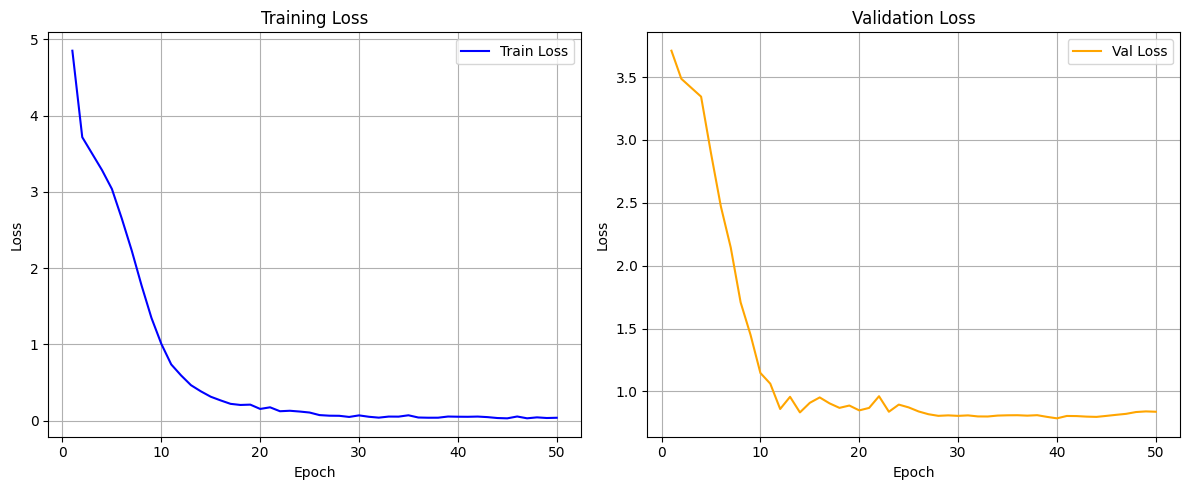

In [25]:
epoch_range = list(range(1, epochs + 1)) 
# Tạo biểu đồ
plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_losses, label="Train Loss", color="blue")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epoch_range, val_losses, label="Val Loss", color="orange")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()